# ARIMA 自回归差分移动平均模型预测车牌成交价

####  prepare bid history price data

read from html: http://www.yunpaiwang.net/jiagezoushi/

In [116]:
%matplotlib inline
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error

In [64]:
# 先用padas 读取试试看
ls_tables= pd.read_html("http://www.yunpaiwang.net/jiagezoushi/",header=0)
df_bid= pd.concat(ls_tables)

In [65]:
df_bid=df_bid.dropna()
df_bid['price'] =  df_bid['平均成交价'].apply(lambda x: str(x).replace('元','')).astype(np.float)

df_bid.describe()

,投放数量,投标人数,price
count,115.000000,115.000000,115.000000
mean,8690.678261,81398.347826,61648.965217
std,1714.537227,87123.617521,21645.766854
min,4500.000000,10170.000000,15970.000000
25%,7675.500000,19044.500000,40169.000000
50%,8500.000000,25014.000000,66946.000000
75%,9454.500000,144198.000000,82262.000000
max,16000.000000,277889.000000,92250.000000


In [70]:
df_bid.index= df_bid['拍卖时间'].apply(lambda x: datetime.strptime(x+'1','%Y年%m月%d'))
df_bid = df_bid.sort_index()
df_bid.sort_index().tail()

,平均成交价,投放数量,投标人数,拍卖时间,最低成交价,最低成交价格截至时间,price
拍卖时间,,,,,,,
2017-04-01,89850,12196,252273,2017年4月,89800,11:29:59 第154位,89850
2017-05-01,90209,10316,270197,2017年5月,90100,11:29:55 第1145位,90209
2017-06-01,89532,10312,244349,2017年6月,89400,11:29:45 第766位,89532
2017-07-01,92250,10325,269189,2017年7月,92200,11:29:59 第1471位,92250
2017-08-01,91629,10558,256083,2017年8月,91600,11:29:59 第1468位,91629


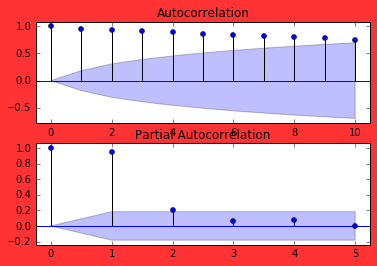

In [71]:
# plot acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
X = df_bid['price']


fig = plt.figure(facecolor='#ff3333')
ax1 = fig.add_subplot(211)
plot_acf(X, ax = ax1, lags=10)
ax2 = fig.add_subplot(212)
plot_pacf(X, ax = ax2, lags=5)
plt.show()


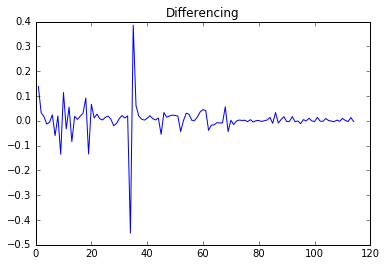

In [110]:
log10 = np.log10(X)
diff = log10 - log10.shift(1)
size = len(diff)
plt.plot(np.arange(size), diff)
plt.title('Differencing')
fig_size = (10, 8)

-320.6434883274504

Residual Description:
                 0
count  114.000000
mean     0.001557
std      0.055858
min     -0.440091
25%     -0.016808
50%     -0.003559
75%      0.024507
max      0.134365


C:\WinPython-64bit-3.4.3.7\python-3.4.3.amd64\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


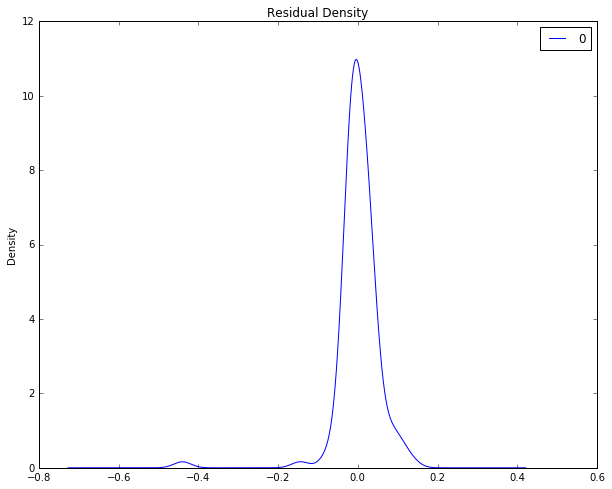

In [102]:
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults, ARMAResults
p, d, q = (4,1,2)
model_fit = ARIMA(log_x, order = (p,d,q)).fit(disp=0)

print(ARIMAResults.aic(model_fit))
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
print('\nResidual Description:\n', residuals.describe())

# pyplot.figure(3)
residuals.plot.kde(figsize=fig_size).set_title('Residual Density')

In [153]:
size = int(len(X) * 0.9)
X = log10.values
iX = log10.index

train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
truth = list()
dates = list()
# print(history.__len__())  # 17386 @ 99%
for t in range(len(test)):
    # print(history.__len__())  # starts at 11590
    model = ARIMA(history, order=(5, 2, 2))
    model_fit = model.fit(disp=-1)
    output = model_fit.forecast()
    y_hat = output[0]
    y_hat_norm = pow(10, y_hat)
    predictions.append(y_hat_norm)
    obs = test[t]
    obs_norm = pow(10, obs)
    truth.append(obs_norm)
    history.append(obs)
    date_index = iX[size + t].date()
    dates.append(date_index)
    # print('Date Index: ', date_index)
    # print('%s' % (iX[date_index].date()))
    print('%s ,predicted=%.2f, expected=%.2f' % (date_index, y_hat_norm, obs_norm))
    
error = mean_squared_error(truth, predictions)
results = zip(test, predictions)
 

C:\WinPython-64bit-3.4.3.7\python-3.4.3.amd64\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\WinPython-64bit-3.4.3.7\python-3.4.3.amd64\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-09-01 ,predicted=87141.71, expected=86523.00
2016-10-01 ,predicted=87512.24, expected=88359.00
2016-11-01 ,predicted=88086.18, expected=88665.00

C:\WinPython-64bit-3.4.3.7\python-3.4.3.amd64\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\WinPython-64bit-3.4.3.7\python-3.4.3.amd64\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



2016-12-01 ,predicted=89398.57, expected=88412.00
2017-01-01 ,predicted=88718.94, expected=87685.00

C:\WinPython-64bit-3.4.3.7\python-3.4.3.amd64\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\WinPython-64bit-3.4.3.7\python-3.4.3.amd64\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



2017-02-01 ,predicted=89215.43, expected=88240.00
2017-03-01 ,predicted=88944.64, expected=87916.00

C:\WinPython-64bit-3.4.3.7\python-3.4.3.amd64\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\WinPython-64bit-3.4.3.7\python-3.4.3.amd64\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



2017-04-01 ,predicted=89304.22, expected=89850.00
2017-05-01 ,predicted=89444.57, expected=90209.00

C:\WinPython-64bit-3.4.3.7\python-3.4.3.amd64\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\WinPython-64bit-3.4.3.7\python-3.4.3.amd64\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



2017-06-01 ,predicted=90435.45, expected=89532.00
2017-07-01 ,predicted=89897.59, expected=92250.00

C:\WinPython-64bit-3.4.3.7\python-3.4.3.amd64\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\WinPython-64bit-3.4.3.7\python-3.4.3.amd64\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



2017-08-01 ,predicted=91734.65, expected=91629.00


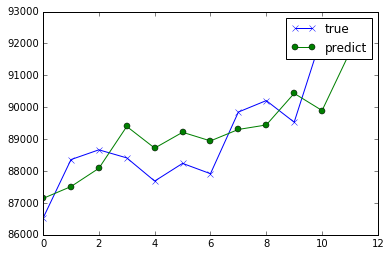

In [155]:
fig = plt.figure()
plt.plot(truth,'b-x',label='true')
plt.plot(predictions,'g-o',label='predict')
plt.legend()

In [156]:
print('\nModel Summary:\n', model_fit.summary())
# plt.savefig('output_figures.pdf', bbox_inches='tight')



Model Summary:
                              ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  112
Model:                 ARIMA(5, 2, 2)   Log Likelihood                 161.875
Method:                       css-mle   S.D. of innovations              0.055
Date:                Mon, 11 Sep 2017   AIC                           -305.750
Time:                        18:59:41   BIC                           -281.284
Sample:                             2   HQIC                          -295.823
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -4.643e-05   7.01e-05     -0.662      0.509        -0.000  9.09e-05
ar.L1.D2.y    -1.5659      0.097    -16.129      0.000        -1.756    -1.376
ar.L2.D2.y    -0.9441      0.179   

In [157]:
from matplotlib.backends.backend_pdf import PdfPages

def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
        print(figs)
    for fig in figs:
        fig.savefig(pp, format='pdf', bbox_inches='tight')
    pp.close()


multipage('0.1.1 output_figures.pdf')

[]
